#**Homography and implementing RANSAC and DLT**
in this report we explain how to find homograpghy matrix between two images from different view usuing functions that should be implemented by ourselve . two important functions that we have to implement are : 

* RANSAC : to omit outliers and gather all inlier points 

* DLT : to compute best homography using inlier points from RANSAC 

in the following we explain the datails more percisely

##**import requiered libraries** 

In [1]:
!pip install opencv-contrib-python==4.4.0.44
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


##**Show original images**

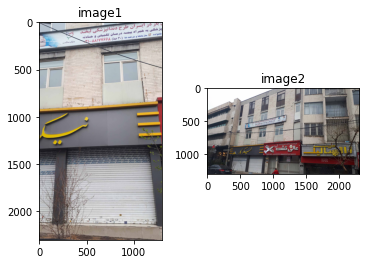

In [2]:
img1=np.array(plt.imread("im03.jpg").astype('float64'))
img2=np.array(plt.imread("im04.jpg").astype('float64'))

plt.subplot(121)
plt.imshow(img1.astype('int32'))
plt.title("image1")

plt.subplot(122)
plt.imshow(img2.astype('int32'))
plt.title("image2")

plt.show()

##**Corners**
to find corners in each image we use  `sift.detectAndCompute()` from opencv package . this function compute keypoints and their descriptors . after calling this function , we show the keypoints for two image alongside each other. 

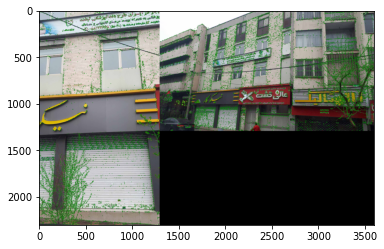

In [3]:
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1.astype(np.uint8),None)
kp2, des2 = sift.detectAndCompute(img2.astype(np.uint8),None)

green_rgb=[0,128,0]
key1 = cv2.drawKeypoints(img1.astype(np.uint8), kp1, None,green_rgb)
key2 = cv2.drawKeypoints(img2.astype(np.uint8), kp2, None,green_rgb)

temp=np.zeros([img1.shape[0]-img2.shape[0],img2.shape[1],3])
con_key2=cv2.vconcat([key2.astype(np.uint8),temp.astype(np.uint8)])
res13 = cv2.hconcat([key1, con_key2])
plt.imshow(res13)
plt.imsave("res22_corners.jpg",res13)
plt.show()



##**Find matches between corners of two image**
to find matches in two image we use `bf.knnMatch(des1,des2,k=2)` from opencv package . this function compute two closest corner in image2 for each corner in image 1 and vice versa . after calling this function , we set the rule that    :          $\frac{L_{1}(first \ nearest)}{L_{1}(second \ nearest)} \leqslant 0.7$ 

this threshold helps us to save corresponding points with the least error. in the following you can see the matched corners(blue color) and all of corners(green)

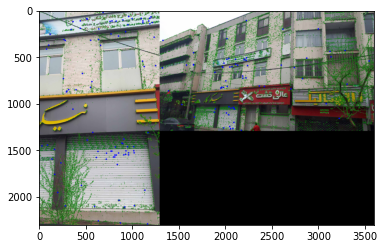

In [4]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good])
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ])

m1=np.copy(key1)
m2=np.copy(key2)
for point in src_pts:
     cv2.circle(m1, tuple(point), 5,(0,0,255),5)

for point in dst_pts:
     cv2.circle(m2, tuple(point), 5,(0,0,255),5)     
temp=np.zeros([img1.shape[0]-img2.shape[0],img2.shape[1],3])
m2=cv2.vconcat([m2,temp.astype(np.uint8)])
res14_correspondences = cv2.hconcat([m1.astype(np.uint8), m2.astype(np.uint8)])
plt.imshow(res14_correspondences)
plt.imsave("res23_correspondences.jpg",res14_correspondences)
plt.show()


##**Plot lines between corresponding points**
to plot lines between matches in two image we use `cv2.drawMatchesKnn` from opencv package : 

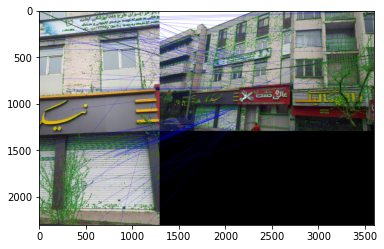

In [5]:
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(key1.astype(np.uint8),kp1,key2.astype(np.uint8),kp2,good,None,[0,0,255],flags=2)

plt.imshow(img3)
plt.imsave("res24_matches.jpg",img3)
plt.show()

in order to distinguish the corresponding lines , we choose 20 random matched point and show the line between them : 


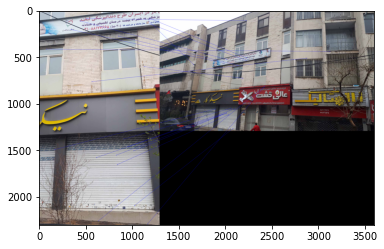

In [6]:
#Generate 20 random numbers between 0 and len(matches)
randomlist = random.sample(range(0, len(good)), 20)
listt=[]
for i in range(0,20):
   listt.append(good[int(randomlist[i])])
img4 = cv2.drawMatchesKnn(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,listt,None,[0,0,255],flags=2)

plt.imshow(img4)
plt.imsave('res25.jpg',img4)
plt.show()


##**RANSAC implmentation**
to implement ransac we do following steps : 

* set the number of iteration and the distance threshold . distnace threshold is used to measeure the error for each corner and if the error is above the distance threshold , the corner is an outlier , otherwise it's inlier . 
for this implementation i set : 

$\boxed{Number \ of \ itteration =4500}$  $\boxed{distance \ threshold=20}$  $\boxed{norm \ type = L_{1}  \ norm}$

* in each itteration , we choose 4 corresponding points  rendomly, and compute the homography using DLT 

* in each itteration , after calculating homography matrix by DLT , we compute error for each corresponding points cuased by this homography matrix  with respect to $distance \ threshold$ . if the error is above threshold we assume the corresponding point is inlier , otherwise it's conidered to be outlier 

* for each itteration we compute the reliability of our homography matrix by following formula : $\boxed{Reliability_{ \ in \ each \ itteration}=\frac{number \ of \ inliers \ in \ that \ itteration}{number \ of \ all \ corresponding \ points}}$

* in each itteration we compare the reliability of that itteration with the maximum reliability of previous itterations and if it's above the maximum of previous ones , we update the maximum reliability we reach and also we update list of inliers based on that .

* at the end of itterations , we have the list of inliers , based on the maximum reliability and give this list to DLT function to return us the best approximation for homography matrix 

In [7]:
def ransac(src,dst):
  final_list_index=[]
  itteration=4500
  dis_threshold=20
  accuracy=0
  #iterate for 4500 iteration
  for iter in range(itteration):
    temp_list=[]
    randomlist = random.sample(range(0, len(src)), 4)
    temp_src=np.zeros_like(src[:4,:])
    temp_dst=np.zeros_like(src[:4,:])
    #choose 4 arbitrary points
    for c,i in enumerate(randomlist):
        temp_src[c,:]=src[i,:]
        temp_dst[c,:]=dst[i,:]

    #find homography between these coresponding points    
    temp_homo=dlt(temp_src,temp_dst)
    
    counter=0 
    #check erro rate for each candidate point
    for i in range(0,len(src[:,1])):
        x=np.ones([3,1])
        x[:2,0]=src[i,:].reshape(2)
        x.reshape(3)
        x_prime=np.dot(temp_homo,x)
        x_prime=(x_prime/x_prime[2,0])[:2,0].reshape(1,2)
        difference=np.sum(np.abs(x_prime[:2]-dst[i,:]))
           
        if(difference<dis_threshold):
             counter+=1
             temp_list.append(i)
      
    temp_acc=counter/len(src[:,0]) 
    if(temp_acc>accuracy):
         accuracy=temp_acc
         final_list=temp_list
  return final_list

##**Effect of using RANSAC**
below we can see the number of corresponding points and number of inliers after using ransac : 

In [10]:
good = []
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append(m)
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)  
list_1=ransac(src_pts,dst_pts)
print(f"number of corresponding points : {len(good)}")
print(f"number of inliers after implementing RANSAC : {len(list_1)}")

number of corresponding points : 98
number of inliers after implementing RANSAC : 39


after using RANSAC we show both inlier with red line and correspnding points(contain inlier and outlier point) with blue line :

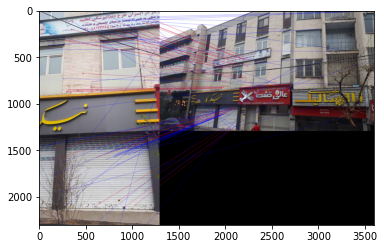

In [11]:
good=[]
# Apply ratio test
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

mask=np.zeros([len(good),1])
for i in range(0,len(matches)):
     if(i in list(list_1)):
        mask[i,0]=1
              
res17 = cv2.drawMatchesKnn(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,good,None,[0,0,255],flags=2)
fl=flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG + cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
res17 = cv2.drawMatchesKnn(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,good,res17,matchColor=(255, 0, 0), singlePointColor=(255, 0, 0),matchesMask=mask,flags=fl)
plt.imshow(res17)
plt.imsave("res26.jpg",res17)
plt.show()

##**Do we have mismatches ?** 
if we plot the inlier lines we have the image below : 

as we can see , all of our inliers are true and they are not mismatch 

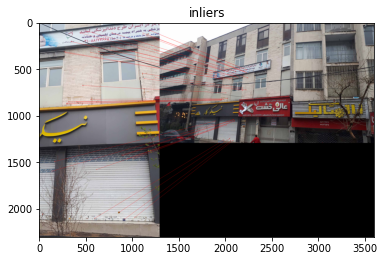

In [12]:
good=[]
# Apply ratio test
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append(m)
draw_params = dict(matchColor = (255,0,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask, # draw only inliers
                   flags = 2)
res18 = cv2.drawMatches(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,good,None,**draw_params)
plt.imshow(res18)
plt.title("inliers")
plt.show()

##**DLT implementation**
to implement DLT we do following steps : 

* suppose we have $n$ inlier points . we have to make coefficient matrix based on followng formula : 

$C=\begin{bmatrix}
-x_{1}^{t} , 0 , y_{1}^{'}x_{1}^{t}\\
0 ,-x_{1}^{t}, x_{1}^{'}x_{1}^{t}\\ 
. \ \ , \ . \ , \  \ . \\
. \ \ , \ . \ , \  \ . \\
-x_{n}^{t} , 0 , y_{n}^{'}x_{n}^{t}\\
0 ,-x_{n}^{t}, x_{n}^{'}x_{n}^{t}
\end{bmatrix}$

* after making coefficient matrix , we have to decompose the matrix , using SVD decompostion : $C=U\Sigma{V^{t}}$ . it is proved that the homography matrix can be driven from the last column of $V$ . that is : 

$homography \ vector=\begin{bmatrix}
h_{1}\\
h_{2}\\ 
. \\
. \\
h_{8}\\
h_{9}
\end{bmatrix}=V(:,end)$

to compute SVD decomposition we can use `np.linalg.svd()` 

* at the end we  use `cv2.reshape(3,3)` to make our homography vector to matrix .

In [9]:
def dlt(src,dst):
    size=len(src[:,0])
    A=np.zeros([size*2,9])
    for i in range(0,size):
      x=src[i,0]
      y=src[i,1]
      x_p=dst[i,0]
      y_p=dst[i,1]
      temp=np.array([[-x,-y,-1,0,0,0,x*y_p,y*y_p,y_p],
                     [0,0,0,-x,-y,-1,x*x_p,y*x_p,x_p]])
      A[2*i:2*(i+1),:]=temp
    #----------------------------
    #svd decomposition 
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    h=np.zeros([9,1])
    v=(np.array(vh).transpose())  #answer is the last column of v in svd decompostion
    row,colum=v.shape
    h=v[:,colum-1]
    homography_matrix=h.reshape(3,3)
    homography_matrix/=homography_matrix[2,2]
    temp=np.copy(homography_matrix[1,:])
    homography_matrix[1,:]=homography_matrix[0,:]
    homography_matrix[0,:]=temp
    return homography_matrix

##**Homograpy matrix from image 2 to image 1 computed by DLT**

In [13]:
src_ransac=np.zeros([len(list_1),2])
dst_ransac=np.zeros([len(list_1),2])

for i,number in enumerate(list_1):
    src_ransac[i,:]=src_pts[number,:]
    dst_ransac[i,:]=dst_pts[number,:]
original_homo=dlt(src_ransac,dst_ransac)
inverse_of_matrix=np.linalg.inv(original_homo)
print(inverse_of_matrix/inverse_of_matrix[2,2])

[[ 3.57366015e+00  2.80799137e-01 -2.31508447e+03]
 [ 4.44465248e-02  2.22920507e+00 -1.09423628e+03]
 [ 8.62364825e-05 -1.74121104e-04  1.00000000e+00]]


$H=\begin{bmatrix}
3.59978649e+00 \ \ \ , \ \ 2.91729574e-01 \ \ \ \ \ , -2.33942389e+03\\
4.24846380e-02 \ \ ,2.23908469e+00\ , \ -1.09829608e+03\\ 
8.82454440e-05 \ \ \ \ \ \ , \ \ \ \  \  -1.72240676e-04 \  \ \ \ , \ \ \ \  1
\end{bmatrix}$

##**Show warped version of image1**

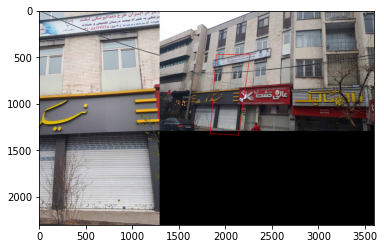

In [14]:
h,w = img1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,original_homo)
temp=np.copy(img2)
temp1=cv2.vconcat([temp.astype(np.uint8),np.zeros([500,img2.shape[1],3]).astype(np.uint8)])
temp = cv2.polylines(temp1,[np.int32(dst)],True,255,3, cv2.LINE_AA)
temp1=cv2.vconcat([temp.astype(np.uint8),np.zeros([img1.shape[0]-temp.shape[0],img2.shape[1],3]).astype(np.uint8)])

res19 = cv2.hconcat([img1.astype(np.uint8), temp1.astype(np.uint8)])
plt.imshow(res19)
plt.imsave("res28.jpg",res19)
plt.show()   

##**Normilizer**
we know that sometimes , homograpgy matrix map some of image's pixel to negative pixel when we warp the image . so we define a function `norimilize_matrix` that remove the negative offset of homography matrix and move the negative pixels to positive . 

In [15]:
def normilizer_matrix(src,hom):
    final=np.copy(hom)
    h,w=src.shape[:2]
    p=[[0,w,w,0],[0,0,h,h],[1,1,1,1]]
    p_prime=np.array(np.dot(hom, p))
    p_zegond=p_prime/p_prime[2,:]
    x_min=np.min(p_zegond[0,:])
    y_min=np.min(p_zegond[1,:])
    t=np.array([[1,0,0],[0,1,0],[0,0,1]])
    if(x_min<0):
       t[0,2]=x_min*-1.2
    if(y_min<0):  
       t[1,2]=y_min*-1.2
    return np.dot(t,final)   

##**Final result**

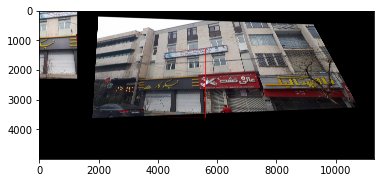

In [16]:
inverse_of_matrix=np.linalg.inv(original_homo)
keke=inverse_of_matrix
inverse_of_matrix=normilizer_matrix(img2,inverse_of_matrix)
inverse_of_matrix/=inverse_of_matrix[2,2]
dsz=(10000,5000)
out = cv2.warpPerspective(img2,inverse_of_matrix,dsz,flags=cv2.INTER_LINEAR)
dst1 = cv2.perspectiveTransform(dst,inverse_of_matrix)
temp=np.copy(out)
temp = cv2.polylines(out,[np.int64(dst1)],True,255,3, cv2.LINE_AA)


con_ver=np.zeros([temp.shape[0]-img1.shape[0],img1.shape[1],3])
con_img1=cv2.vconcat([img1.astype(np.uint8),con_ver.astype(np.uint8)])
res20 = cv2.hconcat([con_img1, temp.astype(np.uint8)])

plt.imshow(res20.astype(np.uint8))
plt.imsave("res29.jpg",out.astype(np.uint8))
plt.imsave("res30.jpg",res20.astype(np.uint8))
plt.show()

##**Parameters**
$1) number \ of \ itteration \ in \ RANSAC=4500$

$2) H=\begin{bmatrix}
3.59978649e+00 \ \ \ , \ \ 2.91729574e-01 \ \ \ \ \ , -2.33942389e+03\\
4.24846380e-02 \ \ ,2.23908469e+00\ , \ -1.09829608e+03\\ 
8.82454440e-05 \ \ \ \ \ \ , \ \ \ \  \  -1.72240676e-04 \  \ \ \ , \ \ \ \  1
\end{bmatrix}$

$3) \ Threshold \ for \ RANSAC=20$

